In [140]:
# Loading packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import sys
import matplotlib.colors as mcolors
from Levenshtein import distance


import torch
import torch.nn as nn
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from torch.utils.data import TensorDataset

from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem

--------------

In [141]:
# Load only IC50 data
df = pd.read_csv("./data/IC50_df.csv")
df.head(2)

,Ligand SMILES,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,IC50 (nM),BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,IC50_class
0,COc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1,3-((4-Methoxyphenyl)-amino)-4-((3-chlorophenyl...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,5800.0,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,weak
1,Oc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1,3-((4-Hydroxyphenyl)amino)-4-((3-chlorophenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,1000.0,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,weak


In [142]:
# copy the df
df_CDK = df.copy()

# list one CDK 
df_CDK.groupby("Target Name")["BindingDB Ligand Name"].nunique().sort_values(ascending=False).head(1)

Target Name
Cyclin-dependent kinase 2/G1/S-specific cyclin-E1    1156
Name: BindingDB Ligand Name, dtype: int64

In [143]:
# make the column IC50 as the log value of that column
df_CDK["IC50 log"] = np.log(df_CDK["IC50 (nM)"].values)
# drop the rows with nan values
df_CDK = df_CDK.dropna(subset=["IC50 log"])

In [144]:
df_CDK.isna().sum()

Ligand SMILES                                                  0
BindingDB Ligand Name                                          0
Target Name                                                    0
Target Source Organism According to Curator or DataSource    265
IC50 (nM)                                                      0
BindingDB Target Chain Sequence                                0
UniProt (SwissProt) Entry Name of Target Chain                19
IC50_class                                                     0
IC50 log                                                       0
dtype: int64

In [145]:
df_CDK.shape

(6486, 9)

In [146]:
# Take one CDK reindex
ligands_df_CDK2_G1 = df_CDK[df_CDK["Target Name"] == "Cyclin-dependent kinase 2/G1/S-specific cyclin-E1"]
# reset index
ligands_df_CDK2_G1.reset_index(drop=True, inplace=True)
ligands_df_CDK2_G1.shape # 1206, 8

(1131, 9)

In [147]:
# Fingerprints
PandasTools.AddMoleculeColumnToFrame(ligands_df_CDK2_G1,'Ligand SMILES','Molecule')
ligands_df_CDK2_G1[["Ligand SMILES","Molecule"]].head(1)

/opt/anaconda3/lib/python3.12/site-packages/rdkit/Chem/PandasTools.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,Ligand SMILES,Molecule
0,CC(=O)Nc1cccc2-c3[nH]nc(c3C(=O)c12)-c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x331b8fd10>


In [148]:
# are there nans
ligands_df_CDK2_G1.Molecule.isna().sum()

0

[0 0 0 ... 0 0 0]


[19:32:29] DEPRECATION WARNING: please use MorganGenerator


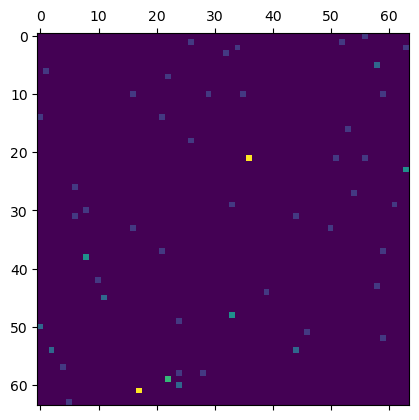

In [149]:
# vectorize the ligands

def mol2fp(mol):
    fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
     

# visualize one example fingerprint
fp = mol2fp(Chem.MolFromSmiles(ligands_df_CDK2_G1.loc[67,"Ligand SMILES"]))
print(fp)
plt.matshow(fp.reshape(64, -1), cmap="viridis")

In [150]:
# find all the different values in the fp array
np.unique(fp)

array([0, 1, 2, 3, 4, 6], dtype=int8)

In [151]:
# Vectorize all the ligands
ligands_df_CDK2_G1["FPs"] = ligands_df_CDK2_G1.Molecule.apply(mol2fp)

[19:32:29] DEPRECATION WARNING: please use MorganGenerator
[19:32:29] DEPRECATION WARNING: please use MorganGenerator
[19:32:29] DEPRECATION WARNING: please use MorganGenerator
[19:32:29] DEPRECATION WARNING: please use MorganGenerator
[19:32:29] DEPRECATION WARNING: please use MorganGenerator
[19:32:29] DEPRECATION WARNING: please use MorganGenerator
[19:32:29] DEPRECATION WARNING: please use MorganGenerator
[19:32:29] DEPRECATION WARNING: please use MorganGenerator
[19:32:29] DEPRECATION WARNING: please use MorganGenerator
[19:32:29] DEPRECATION WARNING: please use MorganGenerator
[19:32:29] DEPRECATION WARNING: please use MorganGenerator
[19:32:29] DEPRECATION WARNING: please use MorganGenerator
[19:32:29] DEPRECATION WARNING: please use MorganGenerator
[19:32:29] DEPRECATION WARNING: please use MorganGenerator
[19:32:29] DEPRECATION WARNING: please use MorganGenerator
[19:32:29] DEPRECATION WARNING: please use MorganGenerator
[19:32:29] DEPRECATION WARNING: please use MorganGenerat

In [152]:
# Stack the FPs
X = np.stack(ligands_df_CDK2_G1["FPs"].values)
y = np.log10(ligands_df_CDK2_G1["IC50 (nM)"].values)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1131, 4096)
y shape: (1131,)


In [153]:
X, y

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int8),
 array([2.38021124, 2.20411998, 2.44715803, ..., 2.2278867 , 0.84509804,
        2.01283722]))

Creating train, test & validation datasets from the given dataset.

In [154]:
y = y.reshape((-1,1))
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.10, random_state=42)

In [155]:
X_train.shape

(915, 4096)

In [156]:
# Normalizing output using standard scaling
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [157]:
# We'll remove low variance features

feature_select = VarianceThreshold(threshold=0.05) #TODO: find the best threshold
X_train = feature_select.fit_transform(X_train)
X_validation = feature_select.transform(X_validation)
X_test = feature_select.transform(X_test)
X_train.shape

(915, 280)

In [158]:
# Let's get those arrays transfered to the GPU memory as tensors
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If you don't have a GPU, buy a graphics card. I have for a long time used a 1060 GTX, which is not that expensive anymore.
X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
X_validation = torch.tensor(X_validation, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()
y_validation = torch.tensor(y_validation, device=device).float()
X_train

cpu


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [159]:
X_train.shape

torch.Size([915, 280])

In [160]:
# define the train and validation loader for the model
train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=256,
                                          shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                          batch_size=256,
                                          shuffle=False)

In [161]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
        # Three layers and a output layer
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer
        #Layer normalization for faster training
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)        
        #LeakyReLU will be used as the activation function
        self.activation = nn.LeakyReLU()
        #Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
     
    def forward(self, x):# Forward pass: stacking each layer together
        # Fully connected =&amp;gt; Layer Norm =&amp;gt; LeakyReLU =&amp;gt; Dropout times 3
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)
        #Final output layer
        out = self.fc_out(out)
        return out

In [162]:
# Defining the hyperparameters
input_size = X_train.size()[-1]     # The input size should fit our fingerprint size
hidden_size = 1024   # The size of the hidden layer
dropout_rate = 0.80    # The dropout rate
output_size = 1        # This is just a single task, so this will be one
learning_rate = 0.001  # The learning rate for the optimizer

# Defining the model
model = Net(input_size, hidden_size, dropout_rate, output_size)

In [163]:
model.cpu()

Net(
  (fc1): Linear(in_features=280, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_out): Linear(in_features=1024, out_features=1, bias=True)
  (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.8, inplace=False)
)

In [164]:
# the loss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [165]:
model.train() #Ensure the network is in "train" mode with dropouts active
epochs = 200
for e in range(epochs):
    running_loss = 0
    for fps, labels in train_loader:
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pa
         
        output = model(fps) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        optimizer.step() # Optimize the weights
         
        running_loss += loss.item()
    else:
        if e%10 == 0:
            validation_loss = torch.mean(( y_validation - model(X_validation) )**2).item()
            print("Epoch: %3i Training loss: %0.2F Validation loss: %0.2F"%(e,(running_loss/len(train_loader)), validation_loss))


Epoch:   0 Training loss: 2.27 Validation loss: 1.42
Epoch:  10 Training loss: 0.67 Validation loss: 0.50
Epoch:  20 Training loss: 0.39 Validation loss: 0.37
Epoch:  30 Training loss: 0.31 Validation loss: 0.28
Epoch:  40 Training loss: 0.26 Validation loss: 0.33
Epoch:  50 Training loss: 0.24 Validation loss: 0.27
Epoch:  60 Training loss: 0.22 Validation loss: 0.26
Epoch:  70 Training loss: 0.21 Validation loss: 0.28
Epoch:  80 Training loss: 0.18 Validation loss: 0.24
Epoch:  90 Training loss: 0.15 Validation loss: 0.27
Epoch: 100 Training loss: 0.15 Validation loss: 0.25
Epoch: 110 Training loss: 0.15 Validation loss: 0.24
Epoch: 120 Training loss: 0.15 Validation loss: 0.25
Epoch: 130 Training loss: 0.14 Validation loss: 0.27
Epoch: 140 Training loss: 0.14 Validation loss: 0.25
Epoch: 150 Training loss: 0.12 Validation loss: 0.27
Epoch: 160 Training loss: 0.13 Validation loss: 0.25
Epoch: 170 Training loss: 0.13 Validation loss: 0.32
Epoch: 180 Training loss: 0.12 Validation loss

Now evaluate the model :

In [166]:
# Evaluate the model
model.eval() #Swith to evaluation mode, where dropout is switched off
y_pred_train = model(X_train)
y_pred_validation = model(X_validation)
y_pred_test = model(X_test)

In [167]:
# Test set loss
torch.mean(( y_test - y_pred_test )**2).item()

0.27255791425704956

In [168]:
# total sum of squares
tss = torch.sum((y_test - torch.mean(y_test))**2).item()
# residual sum of squares
rss = torch.sum((y_test - y_pred_test)**2).item()
# R2 score
r2 = 1 - rss/tss
print(f"R2 score: {r2}")

R2 score: 0.7608763206322242


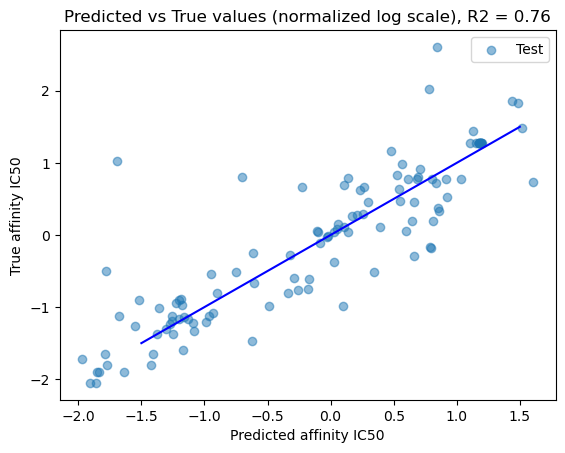

In [169]:
# make all tensors to numpy arrays
def flatten(tensor):
    return tensor.cpu().detach().numpy().flatten()

plt.scatter(flatten(y_pred_test), flatten(y_test), alpha=0.5, label="Test")
# plt.scatter(flatten(y_pred_train), flatten(y_train), alpha=0.1, label="Train")
plt.legend()
plt.title(f"Predicted vs True values (normalized log scale), R2 = {r2:.2f}")
plt.xlabel("Predicted affinity IC50")
plt.ylabel("True affinity IC50")
plt.plot([-1.5, 1.5], [-1.5,1.5], c="b")
plt.show()

In [170]:
def predict_affinity(scaler, model, smiles):
    '''
    Predict the affinity of a ligand using the trained model

    Args:
       - model: the trained model
       - smiles: smiles string of the ligand

    Output:
       - prediction: the predicted affinity (IC50) in the log, normalized scale
    '''
    fp = mol2fp(Chem.MolFromSmiles(smiles)).reshape(1,-1)
    fp = feature_select.transform(fp)
    print(fp.shape)
    fp = torch.tensor(fp, device=device).float()
    # print(fp.shape)
    prediction = model(fp)
    prediction = scaler.inverse_transform(prediction.cpu().detach().numpy())
   #  prediction = np.exp(prediction) # because of the log10
    return prediction

In [171]:
print(ligands_df_CDK2_G1[ligands_df_CDK2_G1["IC50_class"] == "weak"]["Ligand SMILES"][8])

CC(=O)Nc1cccc2-c3n[nH]c(c3C(=O)c12)-c1ccc(Oc2ccccc2)cc1


In [172]:
df_CDK[(df_CDK["IC50_class"] == "weak") & (df_CDK["Target Name"] != "Cyclin-dependent kinase 2/G1/S-specific cyclin-E1")].iloc[4]["Ligand SMILES"]

'CC(C)(C)OC(=O)Nc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1'

In [173]:
df_CDK[(df_CDK["IC50_class"] == "weak") & (df_CDK["Target Name"] == "Cyclin-dependent kinase 2/G1/S-specific cyclin-E1")]#.iloc[4]["Ligand SMILES"]

,Ligand SMILES,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,IC50 (nM),BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,IC50_class,IC50 log
349,CC(=O)Nc1cccc2-c3n[nH]c(c3C(=O)c12)-c1ccc(Oc2c...,"3-(4-Phenoxyphenyl)-5-(acetamido)indeno[1,2-c]...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,2500.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,7.824046
380,CC(=O)Nc1cccc2-c3n[nH]c(C)c3C(=O)c12,"3-Methyl-5-(acetamido)indeno[1,2-c]pyrazol-4-o...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,11000.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,9.305651
381,CCc1[nH]nc2-c3cccc(NC(C)=O)c3C(=O)c12,"3-Ethyl-5-(acetamido)indeno[1,2-c]pyrazol-4-on...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,1500.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,7.313220
382,CCCc1[nH]nc2-c3cccc(NC(C)=O)c3C(=O)c12,"3-n-Propyl-5-(acetamido)indeno[1,2-c]pyrazol-4...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,3700.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,8.216088
385,CC(C)Cc1[nH]nc2-c3cccc(NC(C)=O)c3C(=O)c12,"3-Isobutyl-5-(acetamido)indeno[1,2-c]pyrazol-4...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,3500.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,8.160518
...,...,...,...,...,...,...,...,...,...
8172,CS(=N)(=O)Cc1cccc(Nc2ncnc(n2)-c2ccc(F)cc2OCC(F...,"US9669034, 95 (rac)-4-[2-(2,2-Difluoroethoxy)-...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,1800.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,7.495542
8182,CS(=N)(=O)Cc1cccc(Nc2ncnc(n2)-c2ccc(F)cc2OCCCC...,"US9669034, 100 (rac)-4-[4-Fluoro-2-(4,4,4-trif...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,1300.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,7.170120
8188,CS(=N)(=O)Cc1cccc(Nc2ncnc(n2)-c2ccc(F)cc2OCc2c...,"US9669034, 103 (rac)-4-{4-Fluoro-2-[(2,4,5-tri...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,1200.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,7.090077
8198,CCS(=N)(=O)Cc1cccc(Nc2ncnc(n2)-c2ccc(F)cc2OC)c1,"US9669034, 108 (rac)-N-{3-[(S-ethylsulfonimido...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,1000.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,6.907755


In [174]:
predict_affinity(scaler, model, "CCc1[nH]nc2-c3cccc(NC(C)=O)c3C(=O)c12")

(1, 280)


[19:32:39] DEPRECATION WARNING: please use MorganGenerator


array([[3.0152943]], dtype=float32)

___

# Trying to create the QSAR Model based on linear regression instead of a neural network.

In [175]:
test = ligands_df_CDK2_G1.sample(frac=0.2, random_state=42)
train = ligands_df_CDK2_G1.drop(test.index)

X_train = np.stack(train["FPs"].values)
y_train = train["IC50 log"].values

X_test = np.stack(test["FPs"].values)
y_test = test["IC50 log"].values

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


feature_select = VarianceThreshold(threshold=0.05)  # TODO: find the best threshold

X_train = feature_select.fit_transform(X_train)
X_test = feature_select.transform(X_test)


X_train shape: (905, 4096)
y_train shape: (905,)
X_test shape: (226, 4096)
y_test shape: (226,)


In [176]:
model = sm.OLS(y_train, X_train).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.961
Method:                 Least Squares   F-statistic:                              84.80
Date:                Sat, 07 Dec 2024   Prob (F-statistic):                        0.00
Time:                        19:32:39   Log-Likelihood:                         -1417.5
No. Observations:                 905   AIC:                                      3367.
Df Residuals:                     639   BIC:                                      4646.
Df Model:                         266                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4401      0.515     -0.854      0.393      -1.452       0.572
x2             0.0816      0.402      0.203      0.839      -0.709       0.872
x3            -0.5110      0.356     -1.437      0.151      -1.209       0.187
x4            -2.1275      2.302     -0.924      0.356      -6.648       2.393
x5             6.0055      1.426      4.211      0.000       3.205       8.806
x6            -0.1095      0.656     -0.167      0.868      -1.398       1.179
x7             1.3806      0.608      2.270      0.024       0.186       2.575
x8             0.9623      0.483      1.993      0.047       0.014       1.910
x9            -0.0985      0.758     -0.130      0.897      -1.588       1.390
x10           -0.0723      0.671     -0.108      0.914      -1.390       1.246
x11           -1.9741      0.736     -2.682      0.008      -3.419      -0.529
x12            0.9423      1.278      0.737      0.461      -1.567       3.452
x13           -1.0694      0.221     -4.834      0.000      -1.504      -0.635
x14            0.9458      0.792      1.194      0.233      -0.609       2.501
x15           -1.5183      0.947     -1.603      0.109      -3.378       0.341
x16            2.6619      0.955      2.788      0.005       0.787       4.537
x17           -0.4124      0.728     -0.566      0.571      -1.842       1.017
x18            1.3229      1.049      1.261      0.208      -0.738       3.384
x19            2.0335      2.013      1.010      0.313      -1.919       5.986
x20            8.9945      4.986      1.804      0.072      -0.796      18.785
x21           -0.2045      1.204     -0.170      0.865      -2.568       2.159
x22           -0.7482      0.703     -1.064      0.288      -2.130       0.633
x23           -1.2010      1.436     -0.836      0.403      -4.022       1.620
x24            0.3171      0.470      0.675      0.500      -0.605       1.240
x25           -0.1940      0.675     -0.287      0.774      -1.519       1.131
x26            0.5753      0.620      0.928      0.354      -0.643       1.793
x27            0.5154      0.742      0.695      0.488      -0.942       1.973
x28           -0.6136      0.681     -0.901      0.368      -1.951       0.724
x29            0.8780      1.427      0.615      0.539      -1.924       3.680
x30           -0.7870      0.825     -0.954      0.340      -2.407       0.833
x31            0.5882      0.392      1.502      0.134      -0.181       1.357
x32           -0.2584      0.745     -0.347      0.729      -1.721       1.204
x33            0.1641      0.639      0.257      0.797      -1.090       1.418
x34           -0.2729      1.222     -0.223      0.823      -2.672       2.126
x35            0.0649      0.319      0.204      0.839      -

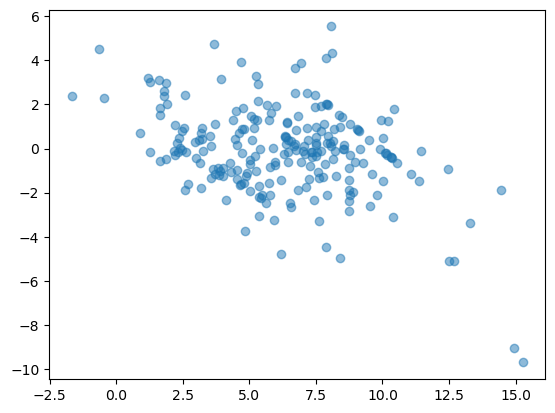

In [177]:
# Residuals plot
plt.scatter(model.predict(X_test), y_test - model.predict(X_test), alpha=0.5)

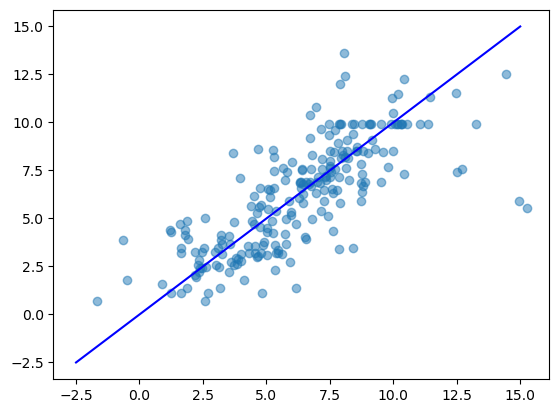

In [178]:
plt.scatter(model.predict(X_test), y_test, alpha=0.5)
plt.plot([-2.5, 15], [-2.5, 15], c="b")

In [185]:
    
def predict_aff(ligand_smiles : str):
    fp = mol2fp(
        Chem.MolFromSmiles(ligand_smiles)
    )

    print(fp)

    X_1_sample = fp

    X_1_sample = feature_select.transform(X_1_sample.reshape(1, -1))

    pred = model.predict(X_1_sample)

    print(f"Predicted values of the IC50 log: {pred}")
    print(f"Non log values: {np.exp(pred)}")
    
    return pred

predict_aff("CCc1[nH]nc2-c3cccc(NC(C)=O)c3C(=O)c12")

[0 0 0 ... 0 0 0]
Predicted values of the IC50 log: [7.41741452]
Non log values: [1664.72382719]


[19:38:13] DEPRECATION WARNING: please use MorganGenerator


array([7.41741452])

In [186]:
predict_aff("COc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1")

[0 0 0 ... 0 0 0]
Predicted values of the IC50 log: [8.11989293]
Non log values: [3360.66088885]


[19:38:35] DEPRECATION WARNING: please use MorganGenerator


array([8.11989293])